# Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

import xgboost as xgb




# Loading all the files

In [2]:

base_path = "/kaggle/input/Cinema_Audience_Forecasting_challenge/"

booknow_visits = pd.read_csv(base_path + "booknow_visits/booknow_visits.csv")
date_info = pd.read_csv(base_path + "date_info/date_info.csv")
booknow_theaters = pd.read_csv(base_path + "booknow_theaters/booknow_theaters.csv")
booknow_booking = pd.read_csv(base_path + "booknow_booking/booknow_booking.csv")
cinepos_booking = pd.read_csv(base_path + "cinePOS_booking/cinePOS_booking.csv")
theater_relation = pd.read_csv(base_path + "movie_theater_id_relation/movie_theater_id_relation.csv")
cinepos_theaters = pd.read_csv(base_path + "cinePOS_theaters/cinePOS_theaters.csv")
sample_sub = pd.read_csv(base_path + "sample_submission/sample_submission.csv")

In [3]:
print(booknow_visits.shape)
print(date_info.shape)
print(booknow_theaters.shape)
print(booknow_booking.shape)
print(cinepos_booking.shape)
print(theater_relation.shape)
print(cinepos_theaters.shape)
print(sample_sub.shape)

(214046, 3)
(547, 2)
(829, 5)
(68336, 4)
(1641966, 4)
(150, 2)
(4690, 5)
(38062, 2)


In [4]:
booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


### Convert date

In [5]:
# Base data
df = booknow_visits.copy()

df["show_date"] = pd.to_datetime(df["show_date"])

df.head()


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


### Merge Date Info


In [6]:
date_info["show_date"] = pd.to_datetime(date_info["show_date"])

df = df.merge(date_info, on="show_date", how="left")

df.head()


,book_theater_id,show_date,audience_count,day_of_week
0,book_00001,2023-01-13,50,Friday
1,book_00001,2023-01-14,64,Saturday
2,book_00001,2023-01-15,58,Sunday
3,book_00001,2023-01-16,44,Monday
4,book_00001,2023-01-18,12,Wednesday


### Audience Distribution


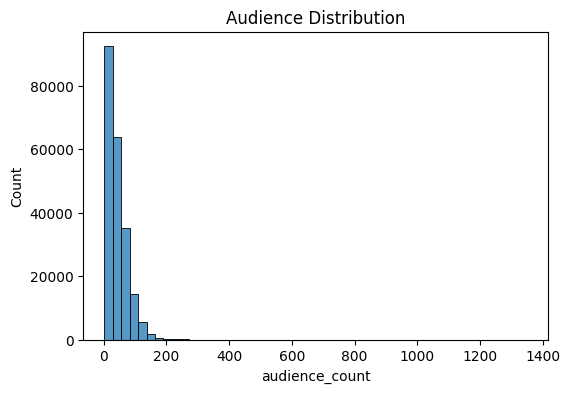

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df["audience_count"], bins=50)
plt.title("Audience Distribution")
plt.show()







***Insight: The distribution is right-skewed, showing a few very high-audience days***

### Audience by Day of Week

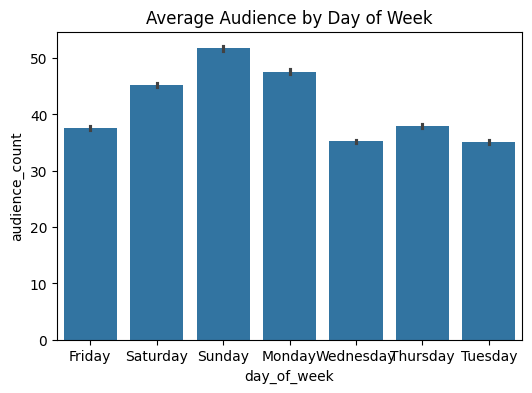

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x="day_of_week", y="audience_count", data=df)
plt.title("Average Audience by Day of Week")
plt.show()







***Insight: Certain weekdays consistently attract higher audience than others.***

### Weekend vs Weekday Audience

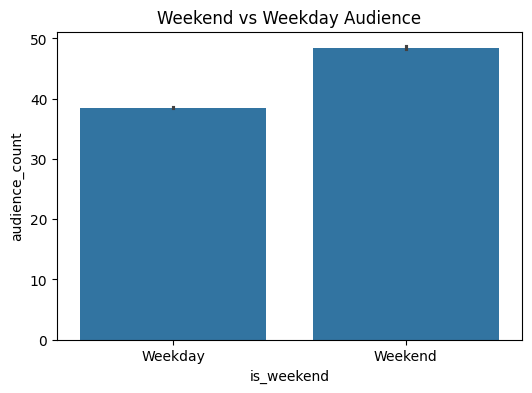

In [9]:
df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)


plt.figure(figsize=(6,4))
sns.barplot(x="is_weekend", y="audience_count", data=df)
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.title("Weekend vs Weekday Audience")
plt.show()





 ***Insight: Weekends generally have higher average audience.***

### Daily Total Audience Trend

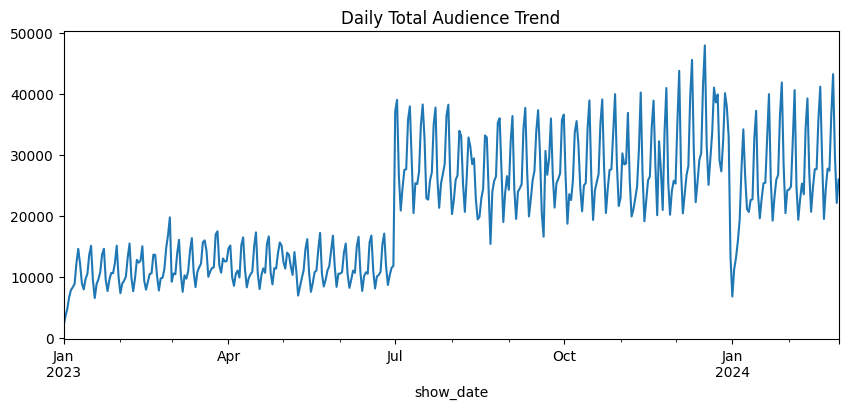

In [10]:
daily_trend = df.groupby("show_date")["audience_count"].sum()

plt.figure(figsize=(10,4))
daily_trend.plot()
plt.title("Daily Total Audience Trend")
plt.show()




***Insight: The trend shows clear fluctuations, indicating seasonal and weekly patterns.***

### Monthly Average Audience

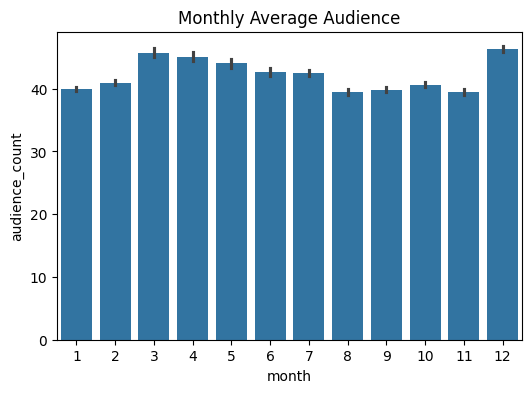

In [11]:
df["month"] = df["show_date"].dt.month

plt.figure(figsize=(6,4))
sns.barplot(x="month", y="audience_count", data=df)
plt.title("Monthly Average Audience")
plt.show()




*Insight: Audience demand varies across months, showing seasonal behavior.*
  


In [12]:
df["day_of_week"].unique()


array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Wednesday', 'Thursday',
       'Tuesday'], dtype=object)

### Merge Theater Info


In [13]:
df = df.merge(booknow_theaters, on="book_theater_id", how="left")

df.head()


,book_theater_id,show_date,audience_count,day_of_week,is_weekend,month,theater_type,theater_area,latitude,longitude
0,book_00001,2023-01-13,50,Friday,0,1,Drama,Area_002,23.00441,79.934515
1,book_00001,2023-01-14,64,Saturday,1,1,Drama,Area_002,23.00441,79.934515
2,book_00001,2023-01-15,58,Sunday,1,1,Drama,Area_002,23.00441,79.934515
3,book_00001,2023-01-16,44,Monday,0,1,Drama,Area_002,23.00441,79.934515
4,book_00001,2023-01-18,12,Wednesday,0,1,Drama,Area_002,23.00441,79.934515


### Online Booking Features


In [14]:
# Convert online booking datetime to date
booknow_booking["show_datetime"] = pd.to_datetime(booknow_booking["show_datetime"])
booknow_booking["show_date"] = booknow_booking["show_datetime"].dt.date
booknow_booking["show_date"] = pd.to_datetime(booknow_booking["show_date"])

# Aggregate daily online bookings
online_agg = (
    booknow_booking
    .groupby(["book_theater_id", "show_date"])
    .agg(
        total_online_tickets=("tickets_booked", "sum")
    )
    .reset_index()
)

# Merge with main df
df = df.merge(online_agg, on=["book_theater_id", "show_date"], how="left")

df.head()



,book_theater_id,show_date,audience_count,day_of_week,is_weekend,month,theater_type,theater_area,latitude,longitude,total_online_tickets
0,book_00001,2023-01-13,50,Friday,0,1,Drama,Area_002,23.00441,79.934515,NaN
1,book_00001,2023-01-14,64,Saturday,1,1,Drama,Area_002,23.00441,79.934515,NaN
2,book_00001,2023-01-15,58,Sunday,1,1,Drama,Area_002,23.00441,79.934515,NaN
3,book_00001,2023-01-16,44,Monday,0,1,Drama,Area_002,23.00441,79.934515,NaN
4,book_00001,2023-01-18,12,Wednesday,0,1,Drama,Area_002,23.00441,79.934515,NaN


In [15]:
df[["total_online_tickets"]].head(10)


,total_online_tickets
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [16]:
cinepos_booking.columns


Index(['cine_theater_id', 'show_datetime', 'booking_datetime', 'tickets_sold'], dtype='object')

### POS Booking Features


In [17]:
# Map cine_theater_id to book_theater_id
cinepos_booking = cinepos_booking.merge(
    theater_relation,
    on="cine_theater_id",
    how="left"
)

cinepos_booking.head()


,cine_theater_id,show_datetime,booking_datetime,tickets_sold,book_theater_id
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1,NaN
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3,NaN
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2,NaN
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5,NaN
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13,NaN


In [18]:
# Convert POS datetime to date
cinepos_booking["show_datetime"] = pd.to_datetime(cinepos_booking["show_datetime"])
cinepos_booking["show_date"] = cinepos_booking["show_datetime"].dt.date
cinepos_booking["show_date"] = pd.to_datetime(cinepos_booking["show_date"])

# Aggregate daily POS tickets
pos_agg = (
    cinepos_booking
    .groupby(["book_theater_id", "show_date"])
    .agg(
        total_pos_tickets=("tickets_sold", "sum")
    )
    .reset_index()
)

# Merge with main df
df = df.merge(pos_agg, on=["book_theater_id", "show_date"], how="left")

df.head()


,book_theater_id,show_date,audience_count,day_of_week,is_weekend,month,theater_type,theater_area,latitude,longitude,total_online_tickets,total_pos_tickets
0,book_00001,2023-01-13,50,Friday,0,1,Drama,Area_002,23.00441,79.934515,NaN,NaN
1,book_00001,2023-01-14,64,Saturday,1,1,Drama,Area_002,23.00441,79.934515,NaN,NaN
2,book_00001,2023-01-15,58,Sunday,1,1,Drama,Area_002,23.00441,79.934515,NaN,NaN
3,book_00001,2023-01-16,44,Monday,0,1,Drama,Area_002,23.00441,79.934515,NaN,NaN
4,book_00001,2023-01-18,12,Wednesday,0,1,Drama,Area_002,23.00441,79.934515,NaN,NaN


# Handling Missing Values

In [19]:
# Fill missing ticket values with 0
df["total_online_tickets"] = df["total_online_tickets"].fillna(0)
df["total_pos_tickets"] = df["total_pos_tickets"].fillna(0)

# Fill missing theater info
df["theater_type"] = df["theater_type"].fillna("Unknown")
df["theater_area"] = df["theater_area"].fillna("Unknown")

# Drop latitude & longitude (not used in final model)
df = df.drop(columns=["latitude", "longitude"])

df.isna().sum()


book_theater_id         0
show_date               0
audience_count          0
day_of_week             0
is_weekend              0
month                   0
theater_type            0
theater_area            0
total_online_tickets    0
total_pos_tickets       0
dtype: int64

#  EDA

### Audience by Theater Type

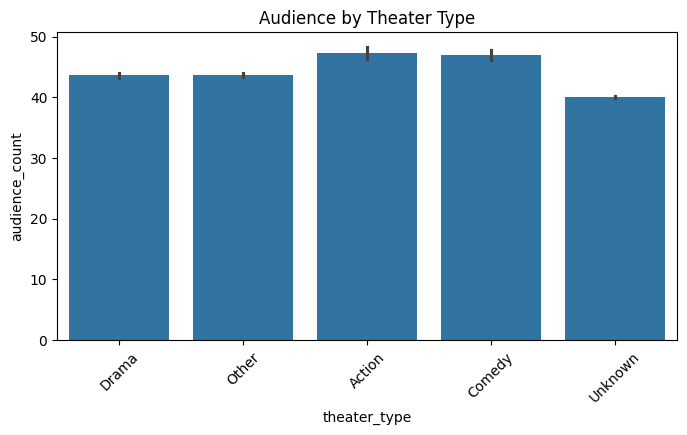

In [20]:
plt.figure(figsize=(8,4))
sns.barplot(x="theater_type", y="audience_count", data=df)
plt.title("Audience by Theater Type")
plt.xticks(rotation=45)
plt.show()




### *Observation: Different theater types show noticeable variation in average audience.*


### Audience by Theater Area

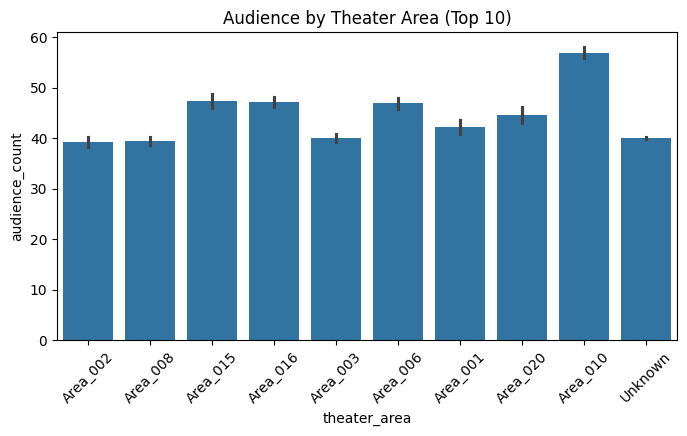

In [21]:
top_areas = df["theater_area"].value_counts().index[:10]

plt.figure(figsize=(8,4))
sns.barplot(
    x="theater_area",
    y="audience_count",
    data=df[df["theater_area"].isin(top_areas)]
)
plt.title("Audience by Theater Area (Top 10)")
plt.xticks(rotation=45)
plt.show()

***Observation: Some areas consistently attract higher audiences than others***

### Online vs Audience

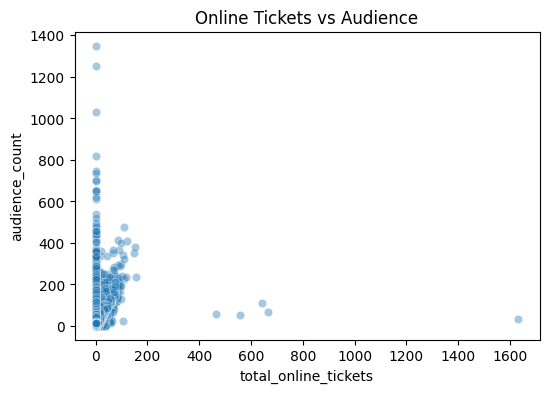

In [22]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="total_online_tickets", y="audience_count", data=df, alpha=0.4)
plt.title("Online Tickets vs Audience")
plt.show()




***Observation: Higher online bookings generally indicate higher final audience,positive but weak correlation***

### POS vs Audience

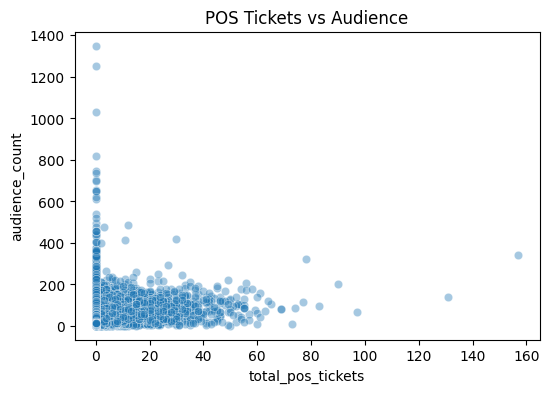

In [23]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="total_pos_tickets", y="audience_count", data=df, alpha=0.4)
plt.title("POS Tickets vs Audience")
plt.show()




***Observation: Offline ticket sales also show a positive relationship with audience***

### Online vs POS Contribution

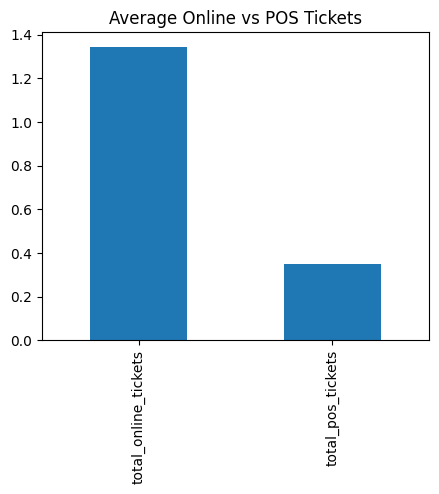

In [24]:
ticket_means = df[["total_online_tickets", "total_pos_tickets"]].mean()

ticket_means.plot(kind="bar", figsize=(5,4))
plt.title("Average Online vs POS Tickets")
plt.show()




***Observation: POS sales contribute more on average than online bookings***

### Audience for missing vs Known Theater info

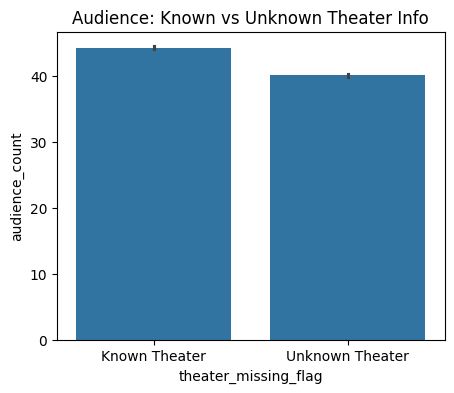

In [25]:
df["theater_missing_flag"] = (df["theater_type"] == "Unknown").astype(int)

plt.figure(figsize=(5,4))
sns.barplot(x="theater_missing_flag", y="audience_count", data=df)
plt.xticks([0,1], ["Known Theater", "Unknown Theater"])
plt.title("Audience: Known vs Unknown Theater Info")
plt.show()




***Observation: Records with missing theater info show different audience behavior***

### Correlation Heatmap

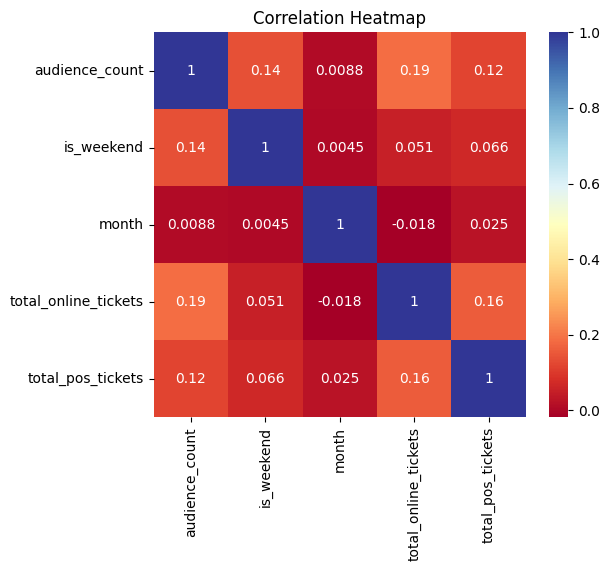

In [26]:
num_cols = [
    "audience_count",
    "is_weekend",
    "month",
    "total_online_tickets",
    "total_pos_tickets"
]

plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="RdYlBu")
plt.title("Correlation Heatmap")
plt.show()




* **total_online_tickets and total_pos_tickets both positively correlate with audience_count**
 * **month has almost no linear correlation (seasonality is non-linear)**


# Feature Engineering

In [27]:
# DATE FEATURES
df["show_date"] = pd.to_datetime(df["show_date"])

df["day_of_week"] = df["show_date"].dt.day_name()
df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)
df["month"] = df["show_date"].dt.month
df["year"] = df["show_date"].dt.year
df["day"] = df["show_date"].dt.day
df["week_of_year"] = df["show_date"].dt.isocalendar().week.astype(int)
df["quarter"] = df["show_date"].dt.quarter
df["dayofmonth"] = df["show_date"].dt.day
df.head()



,book_theater_id,show_date,audience_count,day_of_week,is_weekend,month,theater_type,theater_area,total_online_tickets,total_pos_tickets,theater_missing_flag,year,day,week_of_year,quarter,dayofmonth
0,book_00001,2023-01-13,50,Friday,0,1,Drama,Area_002,0.0,0.0,0,2023,13,2,1,13
1,book_00001,2023-01-14,64,Saturday,1,1,Drama,Area_002,0.0,0.0,0,2023,14,2,1,14
2,book_00001,2023-01-15,58,Sunday,1,1,Drama,Area_002,0.0,0.0,0,2023,15,2,1,15
3,book_00001,2023-01-16,44,Monday,0,1,Drama,Area_002,0.0,0.0,0,2023,16,3,1,16
4,book_00001,2023-01-18,12,Wednesday,0,1,Drama,Area_002,0.0,0.0,0,2023,18,3,1,18


### FEATURES & TARGET

In [28]:
print(df.columns.tolist())


['book_theater_id', 'show_date', 'audience_count', 'day_of_week', 'is_weekend', 'month', 'theater_type', 'theater_area', 'total_online_tickets', 'total_pos_tickets', 'theater_missing_flag', 'year', 'day', 'week_of_year', 'quarter', 'dayofmonth']


In [29]:
# Feature columns
features = [
    "book_theater_id",
    "day_of_week",
    "is_weekend",
    "month",
    "quarter",
    "week_of_year",
    "dayofmonth",
    "year"
]

X = df[features]
y = df["audience_count"]

X.shape, y.shape


((214046, 8), (214046,))

In [30]:
X = df[features].copy()
y = df["audience_count"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nNaNs in X:\n", X.isna().sum())


X shape: (214046, 8)
y shape: (214046,)

NaNs in X:
 book_theater_id    0
day_of_week        0
is_weekend         0
month              0
quarter            0
week_of_year       0
dayofmonth         0
year               0
dtype: int64


### TIME-BASED TRAIN / VALID SPLIT

In [31]:
cutoff = df["show_date"].quantile(0.8)

X_train = X[df["show_date"] <= cutoff]
X_valid = X[df["show_date"] > cutoff]

y_train = y[df["show_date"] <= cutoff]
y_valid = y[df["show_date"] > cutoff]

X_train.shape, X_valid.shape



((171522, 8), (42524, 8))

# Preprocessing Pipeline

In [32]:
categorical_features = [
    "book_theater_id",
    "day_of_week"
]

numerical_features = [
    "is_weekend",
    "month",
    "quarter",
    "week_of_year",
    "dayofmonth",
    "year"
]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)



In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


Train shape: (171236, 8) (171236,)
Val shape: (42810, 8) (42810,)


# Model training and comparison

### Linear Regression

In [34]:

# LINEAR REGRESSION

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

lr_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
lr_model.fit(X_train, y_train)

from sklearn.metrics import r2_score

lr_val_pred = lr_model.predict(X_val)
lr_r2 = r2_score(y_val, lr_val_pred)

print(" Linear Regression R2:", lr_r2)






 Linear Regression R2: 0.45701772809096064


### XGBoost

In [35]:
from xgboost import XGBRegressor


In [36]:
#  XGBoost
xgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['book_theater_id',
                                                   'day_of_week']),
                                                 ('num', StandardScaler(),
                                                  ['is_weekend', 'month',
                                                   'quarter', 'week_of_year',
                                                   'dayofmonth', 'year'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

### LightGBM

In [37]:
from lightgbm import LGBMRegressor


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [38]:


from lightgbm import LGBMRegressor

lgb_model = Pipeline([
    ("preprocess", preprocessor),  # ✅ SAME OBJECT USED WITH LR & XGB
    ("model", LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

lgb_model.fit(X_train, y_train)

# ✅ Now predict safely
lgb_val_pred = lgb_model.predict(X_val)

lgb_r2 = r2_score(y_val, lgb_val_pred)
print("LightGBM R2:", lgb_r2)





[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1767
[LightGBM] [Info] Number of data points in the train set: 171236, number of used features: 835
[LightGBM] [Info] Start training from score 41.659581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM R2: 0.35662595079628534


### Model Comparison

In [39]:
from sklearn.metrics import r2_score

# Predict on validation set
lr_val_pred  = lr_model.predict(X_val)
xgb_val_pred = xgb_model.predict(X_val)
lgb_val_pred = lgb_model.predict(X_val)

# Compute R2 scores
lr_r2  = r2_score(y_val, lr_val_pred)
xgb_r2 = r2_score(y_val, xgb_val_pred)
lgb_r2 = r2_score(y_val, lgb_val_pred)

# Print to verify
print("Linear R2:", lr_r2)
print("XGBoost R2:", xgb_r2)
print("LightGBM R2:", lgb_r2)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Linear R2: 0.45701772809096064
XGBoost R2: 0.36458277702331543
LightGBM R2: 0.35662595079628534


In [40]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost", "LightGBM"],
    "R2_Score": [lr_r2, xgb_r2, lgb_r2]
})

results = results.sort_values(by="R2_Score", ascending=False)
results



,Model,R2_Score
0,Linear Regression,0.457018
1,XGBoost,0.364583
2,LightGBM,0.356626


# Hyperparameter Tuning

In [41]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "model__n_estimators": [300, 500, 700],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0]
}

xgb_tune_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])
random_search = RandomizedSearchCV(
    estimator=xgb_tune_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_xgb_pipeline = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)
print("Best CV R2:", random_search.best_score_)

best_xgb_pred = best_xgb_pipeline.predict(X_valid)
best_xgb_r2 = r2_score(y_valid, best_xgb_pred)
print("Tuned XGBoost Validation R2:", best_xgb_r2)




Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__subsample': 0.7, 'model__n_estimators': 700, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.85}
Best CV R2: 0.4436144431432088
Tuned XGBoost Validation R2: 0.5222885608673096


 # Submission


### TEST FEATURE CREATION

In [42]:

test = sample_sub.copy()

test["book_theater_id"] = test["ID"].str.extract(r"^(.*)_\d{4}-\d{2}-\d{2}$")[0]
test["show_date"] = test["ID"].str.extract(r"(\d{4}-\d{2}-\d{2})")[0]
test["show_date"] = pd.to_datetime(test["show_date"], errors="coerce")

test["day_of_week"] = test["show_date"].dt.dayofweek
test["is_weekend"] = test["day_of_week"].isin([5, 6]).astype(int)
test["month"] = test["show_date"].dt.month
test["quarter"] = test["show_date"].dt.quarter
test["week_of_year"] = test["show_date"].dt.isocalendar().week.astype(int)
test["dayofmonth"] = test["show_date"].dt.day
test["year"] = test["show_date"].dt.year

features = [
    "book_theater_id",
    "day_of_week",
    "is_weekend",
    "month",
    "quarter",
    "week_of_year",
    "dayofmonth",
    "year"
]

X_test = test[features].copy()


X_test["book_theater_id"] = X_test["book_theater_id"].astype(str)
X_test["day_of_week"] = X_test["day_of_week"].astype(str)

print(" X_test recreated:", X_test.shape)
print(" Nulls:\n", X_test.isna().sum())




X_test = X_test.copy()

categorical_features = ["book_theater_id", "day_of_week"]

for col in categorical_features:
    X_test[col] = X_test[col].astype(str)






 X_test recreated: (38062, 8)
 Nulls:
 book_theater_id    0
day_of_week        0
is_weekend         0
month              0
quarter            0
week_of_year       0
dayofmonth         0
year               0
dtype: int64


In [43]:

lr_test_pred  = lr_model.predict(X_test)
xgb_test_pred = xgb_model.predict(X_test)

xgb_test_pred = xgb_test_pred.clip(min=0)
lgb_pred = lgb_model.predict(X_test)

final_pred = 0.5 * lr_test_pred + 0.25 * xgb_test_pred +  0.25 * lgb_pred

final_pred = np.clip(final_pred, 0, None)

final_pred[:5]






/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([39.12327631, 47.38280715, 47.44351541, 39.2082456 , 39.30767264])

In [44]:

submission = sample_sub.copy()
submission["audience_count"] = final_pred

submission.to_csv("submission.csv", index=False)

submission.head()



,ID,audience_count
0,book_00001_2024-03-01,39.123276
1,book_00001_2024-03-02,47.382807
2,book_00001_2024-03-03,47.443515
3,book_00001_2024-03-04,39.208246
4,book_00001_2024-03-06,39.307673


In [45]:
print(submission["audience_count"].describe())
print(submission.head())
print(submission.isna().sum())



count    38062.000000
mean        40.575032
std         15.883603
min          9.288338
25%         29.443682
50%         37.614496
75%         48.444685
max        152.629419
Name: audience_count, dtype: float64
                      ID  audience_count
0  book_00001_2024-03-01       39.123276
1  book_00001_2024-03-02       47.382807
2  book_00001_2024-03-03       47.443515
3  book_00001_2024-03-04       39.208246
4  book_00001_2024-03-06       39.307673
ID                0
audience_count    0
dtype: int64
